<a href="https://colab.research.google.com/github/OliverMaerz/Covid-19/blob/master/Covid19_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 - New Cases, Deaths, Recovered - Death Rate - Reproduction Number (R)

Generated with data from Johns Hopkins CSSE: https://github.com/CSSEGISandData




Set the list of countries we want to take a look at:

In [30]:
selected_countries = ['Argentina', 'Spain', 'Italy', 'Brazil', 'Chile', 
                      'Germany', 'US', 'France', 'United Kingdom']

#selected_countries = ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Peru']


First: Download the Johns Hopkins CSSE global dataset for Covid-19:

In [31]:
!curl -o confirmed.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
!curl -o deaths.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
!curl -o recovered.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  177k  100  177k    0     0  1348k      0 --:--:-- --:--:-- --:--:-- 1348k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  127k  100  127k    0     0   364k      0 --:--:-- --:--:-- --:--:--  364k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  154k  100  154k    0     0  1061k      0 --:--:-- --:--:-- --:--:-- 1061k


Next: Import the libraries we will use for data wrangling and display:

In [32]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [40, 20]
import numpy as np
import pandas as pd

Load the downloaded dataset (csv files) into [Pandas](https://pandas.pydata.org/) dataframes and remove columns we do not need:

In [33]:
confirmed_df = pd.read_csv('confirmed.csv', sep=',', header=0, 
                           error_bad_lines=False)
deaths_df = pd.read_csv('deaths.csv', sep=',', header=0, 
                        error_bad_lines=False)
recovered_df = pd.read_csv('recovered.csv', sep=',', header=0, 
                           error_bad_lines=False)

Define helper functions

In [34]:
# Get a new dataframe with only the countries that are in the 
# selected_countries list and drop the rest
def get_selected_countries(df):
    selected_df = df.loc[df['Country/Region'].isin(selected_countries) & \
                         df['Province/State'].isnull()].copy()
    selected_df.set_index('Country/Region', inplace=True)
    # drop some columns we will no longer need
    selected_df.drop(['Lat', 'Long', 'Province/State'], axis=1, inplace=True)
    # convert the column names to date-time format
    selected_df.columns = pd.to_datetime(selected_df.columns)
    return selected_df


# Get the new cases, deaths, or recovered cases by calculating the difference
# to the previous days for each day
def get_difference_between_days(df):
    diff_df = df.diff(axis=1)
    # drop the first column as there is no previous day to calculate the 
    # difference 
    diff_df.drop(diff_df.columns[0], axis='columns', inplace=True)
    # drop any zero colums
    diff_df = diff_df.loc[:, (diff_df != 0).any(axis=0)]
    # get rid of negative values
    diff_df[diff_df < 0] = 0
    return diff_df
     

## Create dataframe with selected countries and new confirmed cases per day

In [35]:
selected_confirmed_df = get_selected_countries(confirmed_df)
new_confirmed_df = get_difference_between_days(selected_confirmed_df)
new_confirmed_df

,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-05,2020-02-07,2020-02-08,2020-02-09,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-17,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,...,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,2020-06-13,2020-06-14,2020-06-15,2020-06-16,2020-06-17,2020-06-18,2020-06-19,2020-06-20,2020-06-21,2020-06-22,2020-06-23,2020-06-24,2020-06-25,2020-06-26,2020-06-27,2020-06-28,2020-06-29,2020-06-30,2020-07-01,2020-07-02,2020-07-03,2020-07-04,2020-07-05,2020-07-06,2020-07-07,2020-07-08,2020-07-09,2020-07-10,2020-07-11,2020-07-12,2020-07-13,2020-07-14,2020-07-15,2020-07-16,2020-07-17
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Argentina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,6.0,4.0,0.0,...,826.0,1141.0,1226.0,1386.0,1391.0,1531.0,1282.0,1208.0,1374.0,1393.0,1958.0,2060.0,1634.0,1581.0,2146.0,2272.0,2648.0,2606.0,2886.0,2401.0,2189.0,2335.0,2262.0,2667.0,2744.0,2845.0,2590.0,2439.0,2632.0,2979.0,3604.0,3663.0,3367.0,3449.0,2657.0,3099.0,3645.0,4236.0,3637.0,4518.0
Brazil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,9.0,0.0,7.0,5.0,...,15654.0,32091.0,32913.0,30412.0,25982.0,21704.0,17110.0,20647.0,34918.0,32188.0,22765.0,54771.0,34666.0,15762.0,23129.0,39436.0,42725.0,39483.0,46860.0,38693.0,30476.0,24052.0,33846.0,46712.0,48105.0,42223.0,37923.0,26051.0,20229.0,45305.0,44571.0,42619.0,45048.0,39023.0,24831.0,20286.0,41857.0,39924.0,45403.0,34177.0
Chile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,4.0,0.0,...,4696.0,3913.0,5697.0,5636.0,6754.0,6509.0,6938.0,5143.0,5013.0,36179.0,4475.0,6290.0,5355.0,5607.0,4608.0,3804.0,3649.0,4648.0,4296.0,4406.0,4216.0,4017.0,3394.0,2650.0,2498.0,3548.0,3758.0,3685.0,3025.0,2462.0,2064.0,3133.0,3058.0,2755.0,3012.0,2616.0,1836.0,1712.0,2493.0,2741.0
France,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,20.0,19.0,43.0,30.0,61.0,13.0,81.0,92.0,276.0,296.0,177.0,83.0,...,98.0,335.0,397.0,358.0,564.0,393.0,291.0,68.0,227.0,311.0,201.0,569.0,436.0,5.0,325.0,382.0,0.0,0.0,1336.0,0.0,0.0,1680.0,264.0,612.0,473.0,446.0,0.0,0.0,1213.0,341.0,0.0,1168.0,486.0,0.0,0.0,1388.0,0.0,829.0,401.0,709.0
Germany,0.0,0.0,0.0,1.0,3.0,0.0,1.0,3.0,2.0,2.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,19.0,2.0,31.0,51.0,29.0,37.0,66.0,220.0,188.0,129.0,241.0,136.0,...,359.0,397.0,16.0,169.0,535.0,41.0,251.0,164.0,570.0,352.0,1213.0,482.0,371.0,602.0,496.0,712.0,391.0,500.0,665.0,422.0,235.0,349.0,376.0,475.0,477.0,410.0,418.0,325.0,541.0,279.0,356.0,302.0,331.0,377.0,210.0,261.0,276.0,434.0,560.0,595.0
Italy,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,42.0,93.0,74.0,93.0,131.0,202.0,233.0,240.0,566.0,342.0,466.0,587.0,769.0,778.0,1247.0,1492.0,1797.0,...,280.0,283.0,202.0,379.0,163.0,346.0,338.0,301.0,210.0,328.0,331.0,0.0,264.0,224.0,221.0,113.0,577.0,296.0,255.0,175.0,174.0,126.0,142.0,182.0,201.0,223.0,235.0,192.0,208.0,137.0,193.0,214.0,276.0,188.0,234.0,169.0,114.0,162.0,230.0,231.0
Spain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,7.0,2.0,17.0,13.0,39.0,36.0,45.0,57.0,37.0,141.0,100.0,173.0,400.0,...,167.0,249.0,314.0,427.0,502.0,396.0,323.0,181.0,219.0,355.0,585.0,307.0,363.0,334.0,232.0,248.0,334.0,400.0,419.0,564.0,301.0,200.0,301.0,388.0,444.0,442.0,0.0,0.

## Plot new confirmed cases per day

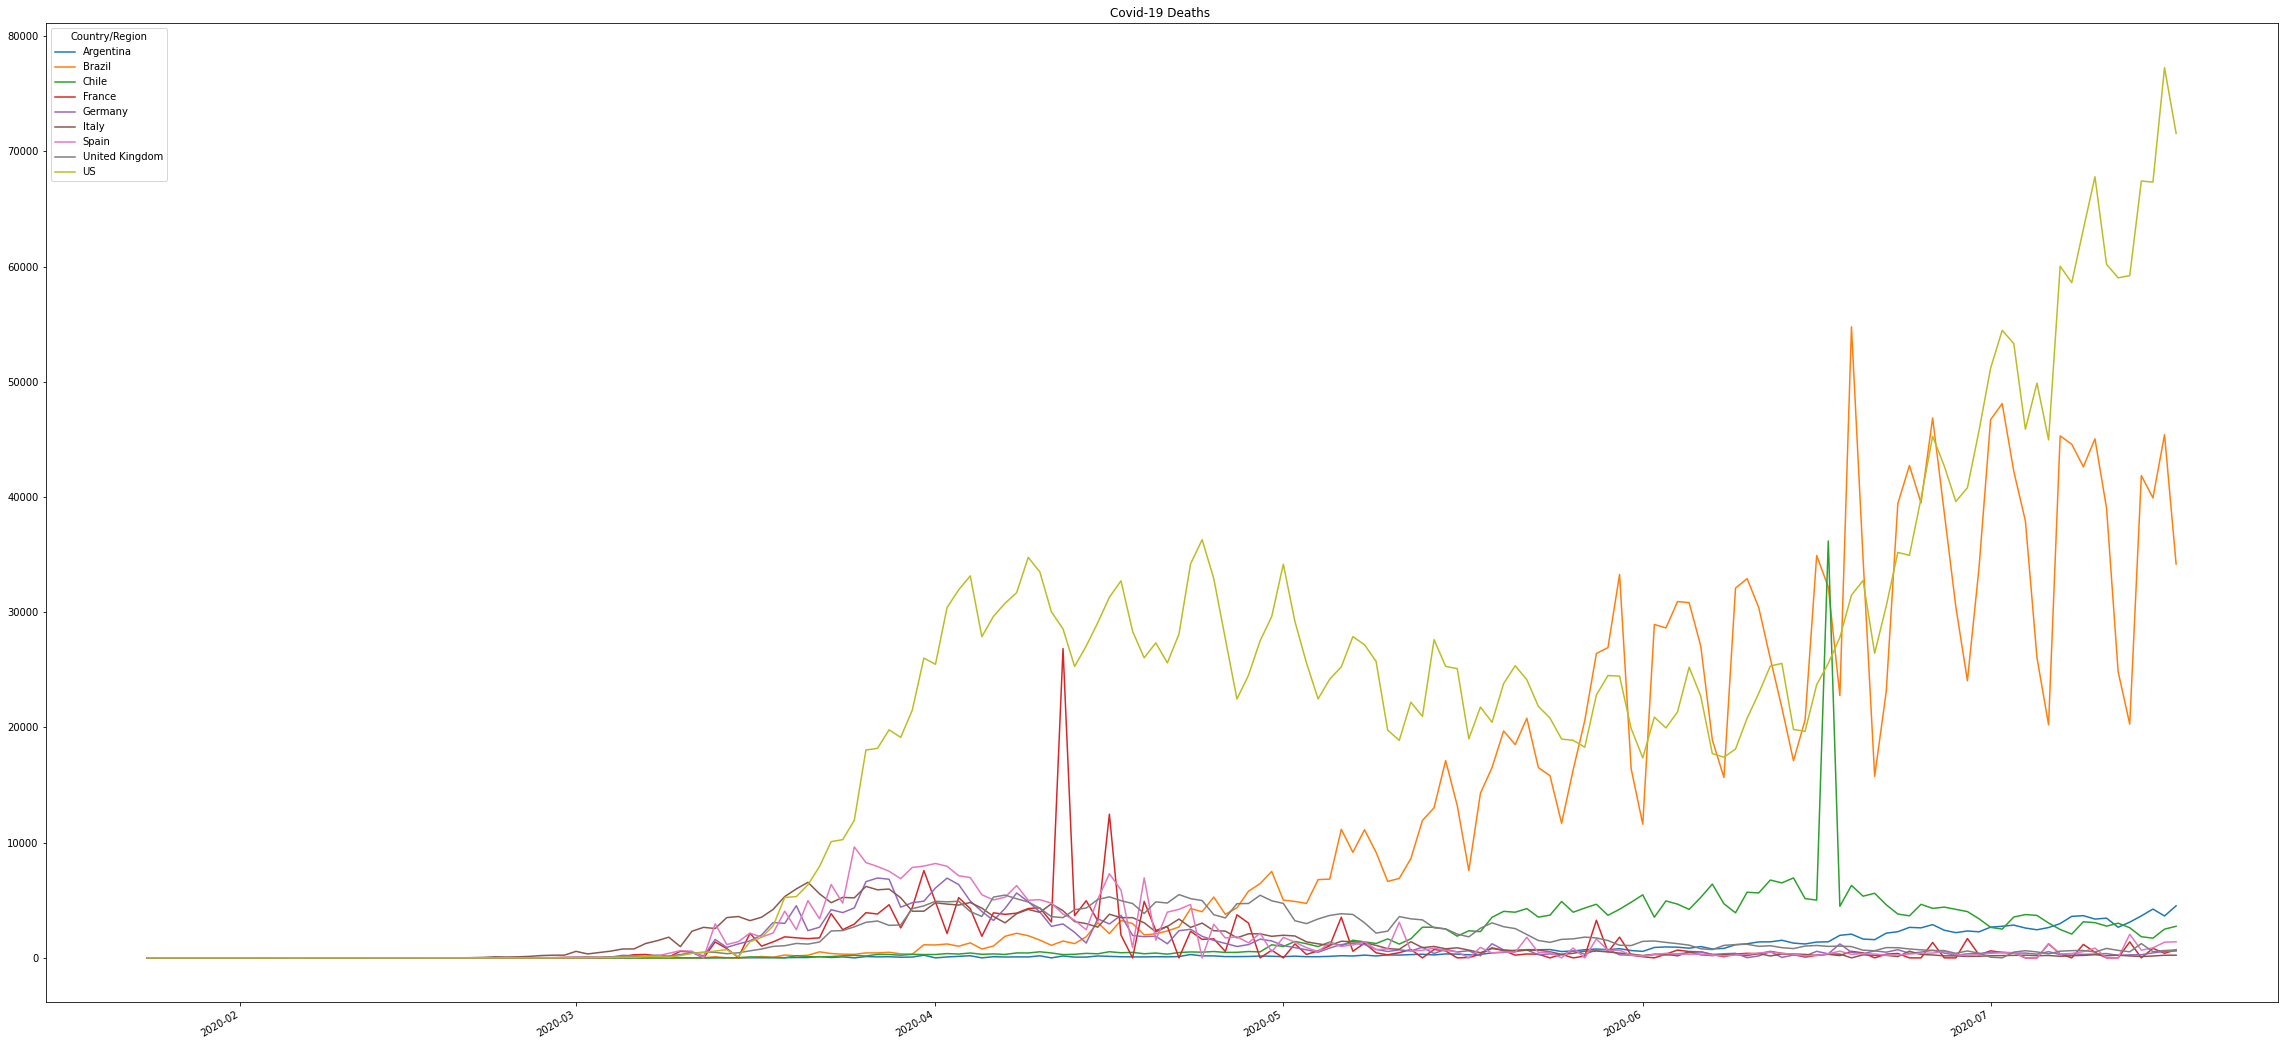

In [36]:
new_confirmed_df.transpose().plot(kind='line', title='Covid-19 Deaths ', 
                                  logy=False)

## Create dataframe with selected countries and number of deaths per day

In [37]:
selected_deaths_df = get_selected_countries(deaths_df)
new_deaths_df = get_difference_between_days(selected_deaths_df)
new_deaths_df

,2020-02-15,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,...,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,2020-06-13,2020-06-14,2020-06-15,2020-06-16,2020-06-17,2020-06-18,2020-06-19,2020-06-20,2020-06-21,2020-06-22,2020-06-23,2020-06-24,2020-06-25,2020-06-26,2020-06-27,2020-06-28,2020-06-29,2020-06-30,2020-07-01,2020-07-02,2020-07-03,2020-07-04,2020-07-05,2020-07-06,2020-07-07,2020-07-08,2020-07-09,2020-07-10,2020-07-11,2020-07-12,2020-07-13,2020-07-14,2020-07-15,2020-07-16,2020-07-17
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Argentina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,4.0,5.0,1.0,4.0,...,29.0,24.0,18.0,30.0,20.0,30.0,18.0,21.0,24.0,35.0,35.0,31.0,13.0,19.0,32.0,35.0,38.0,34.0,34.0,23.0,25.0,48.0,27.0,44.0,34.0,52.0,44.0,26.0,75.0,62.0,50.0,26.0,54.0,36.0,35.0,58.0,65.0,82.0,62.0,66.0
Brazil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,5.0,4.0,10.0,9.0,12.0,13.0,18.0,15.0,19.0,25.0,23.0,...,679.0,1272.0,1274.0,1239.0,909.0,892.0,612.0,627.0,1282.0,1269.0,1238.0,1206.0,1022.0,615.0,680.0,1374.0,1185.0,1141.0,990.0,1109.0,552.0,692.0,1280.0,1038.0,1252.0,1290.0,1091.0,602.0,620.0,1254.0,1223.0,1220.0,1214.0,1071.0,631.0,733.0,1300.0,1233.0,1322.0,1163.0
Chile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,627.0,19.0,192.0,173.0,222.0,231.0,222.0,39.0,21.0,232.0,226.0,252.0,202.0,184.0,23.0,3.0,226.0,172.0,165.0,279.0,162.0,66.0,113.0,65.0,167.0,131.0,141.0,116.0,76.0,50.0,139.0,109.0,99.0,100.0,98.0,45.0,45.0,117.0,104.0,1057.0
France,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,3.0,2.0,8.0,0.0,14.0,15.0,0.0,31.0,12.0,0.0,57.0,0.0,0.0,95.0,207.0,112.0,112.0,186.0,240.0,231.0,365.0,299.0,319.0,292.0,418.0,...,53.0,84.0,23.0,27.0,28.0,24.0,7.0,29.0,109.0,28.0,28.0,14.0,14.0,6.0,21.0,57.0,9.0,19.0,25.0,0.0,0.0,32.0,27.0,17.0,14.0,18.0,0.0,1.0,23.0,11.0,0.0,43.0,23.0,0.0,0.0,22.0,0.0,89.0,17.0,14.0
Germany,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0,2.0,6.0,7.0,4.0,16.0,23.0,17.0,10.0,29.0,34.0,49.0,61.0,75.0,91.0,100.0,112.0,...,10.0,41.0,16.0,20.0,11.0,10.0,8.0,6.0,13.0,31.0,24.0,12.0,8.0,0.0,4.0,15.0,14.0,12.0,25.0,3.0,0.0,8.0,14.0,5.0,11.0,4.0,10.0,3.0,0.0,10.0,14.0,11.0,6.0,7.0,1.0,3.0,4.0,2.0,7.0,1.0
Italy,0.0,1.0,1.0,1.0,4.0,3.0,2.0,5.0,4.0,8.0,5.0,18.0,27.0,28.0,41.0,49.0,36.0,133.0,97.0,168.0,196.0,189.0,250.0,175.0,368.0,349.0,345.0,475.0,427.0,627.0,793.0,651.0,601.0,743.0,683.0,712.0,919.0,889.0,756.0,812.0,...,65.0,79.0,71.0,53.0,56.0,78.0,44.0,26.0,34.0,43.0,66.0,47.0,49.0,24.0,23.0,18.0,0.0,34.0,30.0,8.0,22.0,6.0,23.0,21.0,30.0,15.0,21.0,7.0,8.0,30.0,15.0,12.0,12.0,7.0,9.0,13.0,17.0,13.0,20.0,11.0
Spain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,5.0,7.0,11.0,7.0,19.0,1.0,78.0,62.0,94.0,53.0,191.0,90.0,207.0,213.0,332.0,397.0,539.0,497.0,839.0,718.0,773.0,844.0,821.0,913.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1179.0,7.0,1.0,1.0,1.0,2.0,3.0,8.0,3.0,2.0,3.0,9.0,9.0,4.0,17.0,0.0,0.0,3.0,4.0,4.0,5.0,2.0,0.0,0.0,3.0,3.0,4.0,3.0,4.0
United Kingdom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,4.0,0.0,2.0,1.0,18.0,15.0,22.0,16.0,34.0,43.0,36.0,56.0,35.0,74.0,149.0,187.0,183.0,284.0,294.0,214.0,374.0,...,55.0,289.0,250.0,152.0,204.0,183.0,36.0,38.0,236.0,184.0,137.0,1

## Plot number of deaths per day

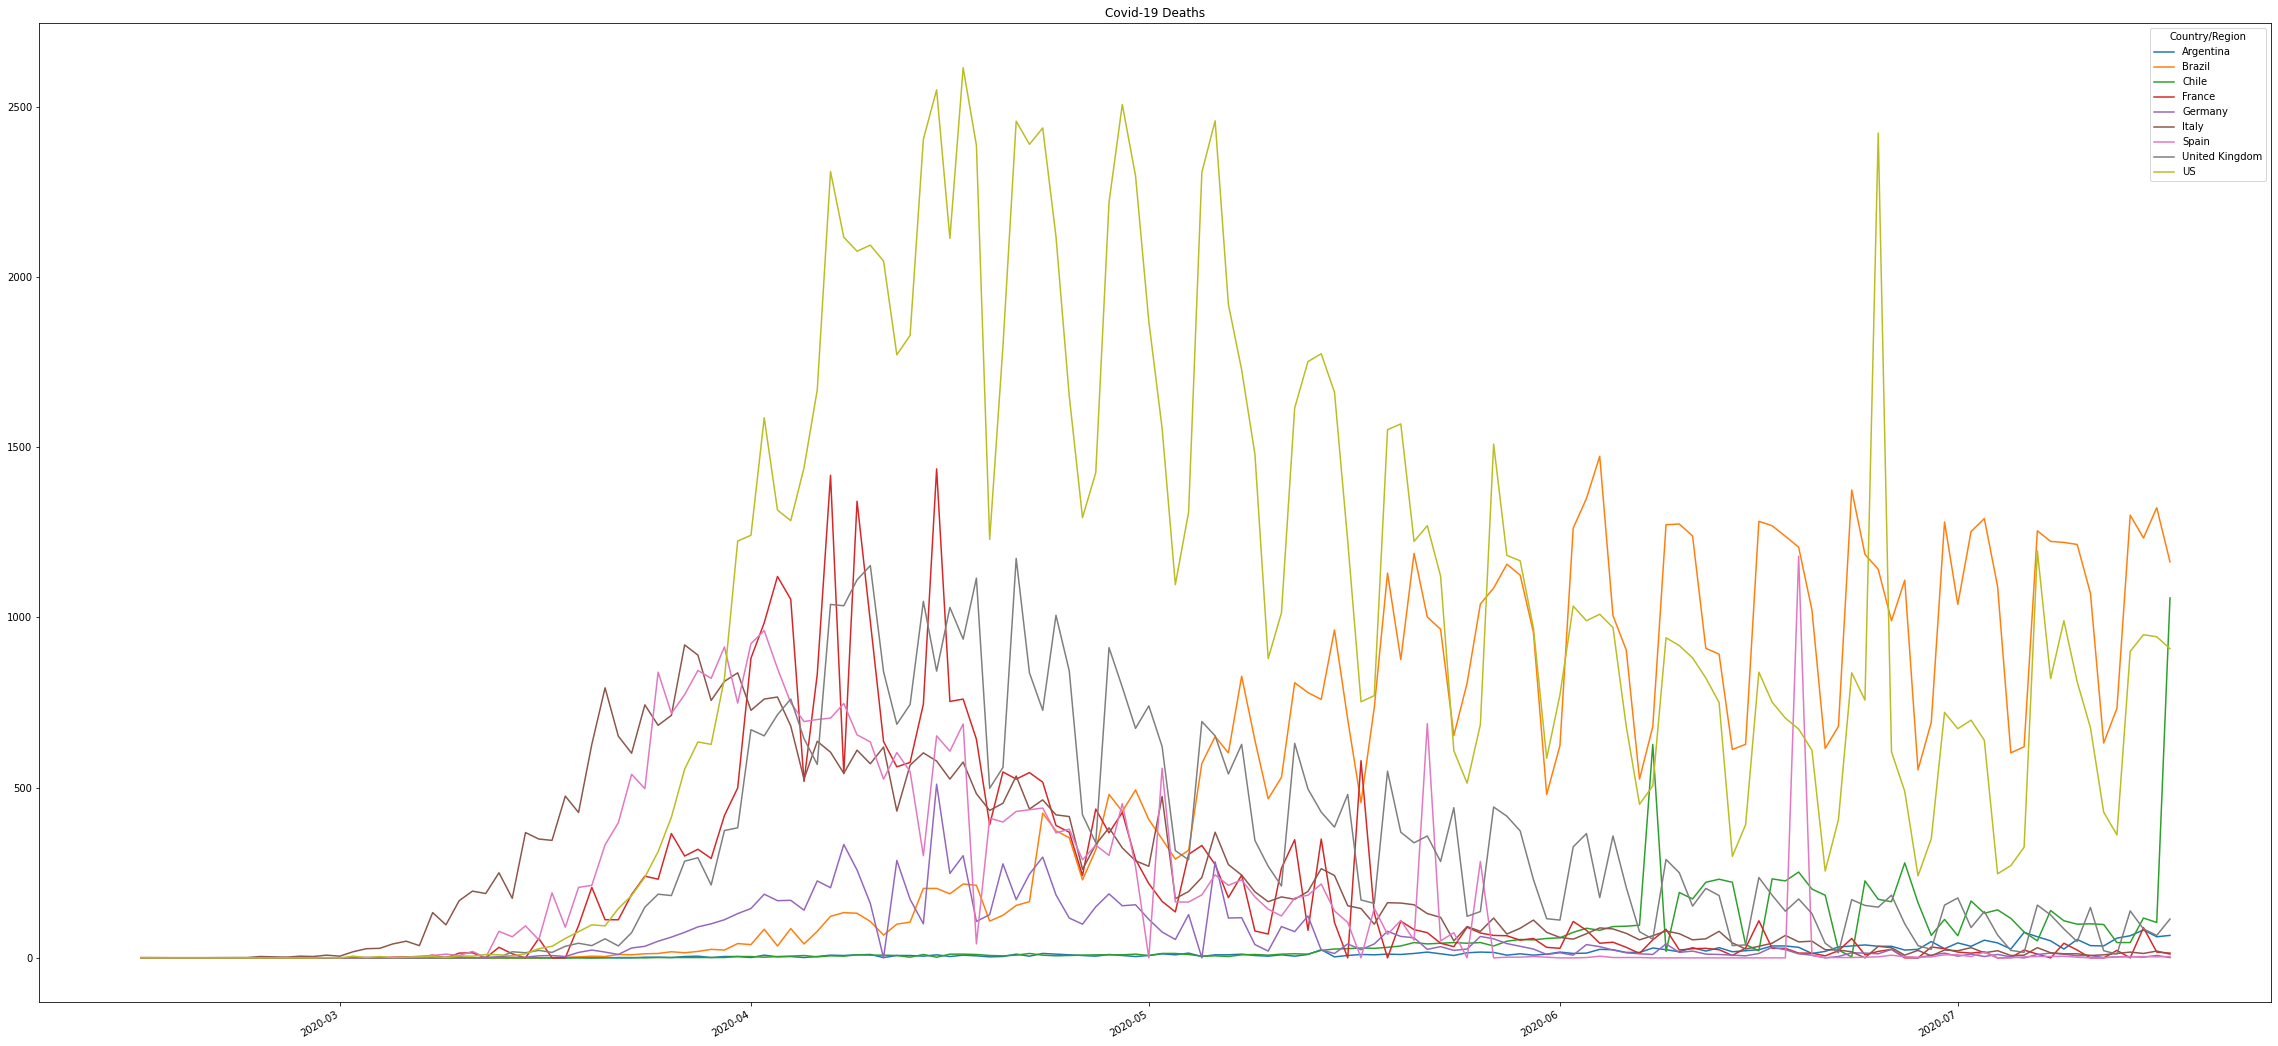

In [38]:
new_deaths_df.transpose().plot(kind='line', title='Covid-19 Deaths', logy=False)

## Create dataframe with selected countries and number of recovered patients per day

In [39]:
selected_recovered_df = get_selected_countries(recovered_df)
new_recovered_df = get_difference_between_days(selected_recovered_df)
new_recovered_df

,2020-02-09,2020-02-12,2020-02-13,2020-02-15,2020-02-16,2020-02-18,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-24,2020-03-25,2020-03-26,...,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,2020-06-13,2020-06-14,2020-06-15,2020-06-16,2020-06-17,2020-06-18,2020-06-19,2020-06-20,2020-06-21,2020-06-22,2020-06-23,2020-06-24,2020-06-25,2020-06-26,2020-06-27,2020-06-28,2020-06-29,2020-06-30,2020-07-01,2020-07-02,2020-07-03,2020-07-04,2020-07-05,2020-07-06,2020-07-07,2020-07-08,2020-07-09,2020-07-10,2020-07-11,2020-07-12,2020-07-13,2020-07-14,2020-07-15,2020-07-16,2020-07-17
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Argentina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,49.0,0.0,11.0,...,396.0,263.0,423.0,341.0,411.0,340.0,481.0,327.0,283.0,338.0,209.0,1130.0,355.0,522.0,425.0,423.0,240.0,972.0,3628.0,727.0,991.0,1004.0,890.0,1012.0,1146.0,1038.0,706.0,1667.0,934.0,1564.0,6407.0,1811.0,671.0,2424.0,1286.0,1479.0,1294.0,1831.0,1822.0,660.0
Brazil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,94305.0,18480.0,17179.0,16049.0,15158.0,14313.0,9705.0,8568.0,12296.0,31041.0,13534.0,17051.0,25148.0,11339.0,13618.0,26227.0,32506.0,19055.0,22875.0,25316.0,18303.0,11793.0,30507.0,29324.0,140050.0,26923.0,6116.0,38314.0,33497.0,44470.0,32832.0,31603.0,45914.0,26727.0,20755.0,26408.0,32174.0,26673.0,47433.0,30989.0
Chile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,9.0,5.0,0.0,...,4098.0,5113.0,4419.0,4664.0,4914.0,5938.0,6408.0,5088.0,7440.0,25699.0,4510.0,5050.0,5118.0,3960.0,4828.0,5173.0,4523.0,4234.0,4104.0,4624.0,4155.0,3944.0,5075.0,4214.0,3804.0,4096.0,4108.0,3588.0,3339.0,3873.0,3490.0,3181.0,3131.0,3061.0,2788.0,2654.0,2664.0,2865.0,3216.0,1513.0
France,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2188.0,1043.0,657.0,1048.0,...,36.0,417.0,296.0,312.0,234.0,205.0,37.0,0.0,224.0,280.0,99.0,174.0,145.0,20.0,76.0,215.0,186.0,184.0,228.0,0.0,0.0,140.0,119.0,165.0,175.0,127.0,0.0,0.0,141.0,130.0,0.0,275.0,0.0,0.0,0.0,0.0,0.0,0.0,136.0,69.0
Germany,0.0,0.0,1.0,0.0,0.0,11.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,7.0,0.0,21.0,0.0,0.0,21.0,0.0,38.0,8.0,67.0,53.0,33.0,2977.0,304.0,2126.0,...,332.0,573.0,501.0,331.0,574.0,435.0,119.0,603.0,150.0,757.0,248.0,125.0,637.0,131.0,403.0,682.0,597.0,342.0,385.0,369.0,139.0,113.0,330.0,1000.0,700.0,500.0,700.0,719.0,441.0,501.0,492.0,575.0,300.0,238.0,148.0,686.0,0.0,900.0,400.0,500.0
Italy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,42.0,1.0,0.0,37.0,66.0,11.0,116.0,138.0,109.0,66.0,33.0,102.0,0.0,321.0,0.0,394.0,527.0,369.0,414.0,192.0,1084.0,415.0,0.0,1632.0,952.0,1302.0,1036.0,999.0,...,747.0,2062.0,1293.0,1399.0,1747.0,1780.0,1505.0,640.0,1516.0,929.0,1089.0,1363.0,546.0,440.0,533.0,1159.0,1526.0,614.0,890.0,969.0,307.0,305.0,1052.0,469.0,366.0,384.0,477.0,164.0,133.0,574.0,825.0,338.0,295.0,306.0,349.0,178.0,335.0,575.0,230.0,237.0
Spain,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,2.0,0.0,151.0,0.0,10.0,324.0,0.0,13.0,498.0,53.0,26.0,481.0,537.0,450.0,1219.0,1573.0,1648.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
United 

## Plot number of recovered patients per day

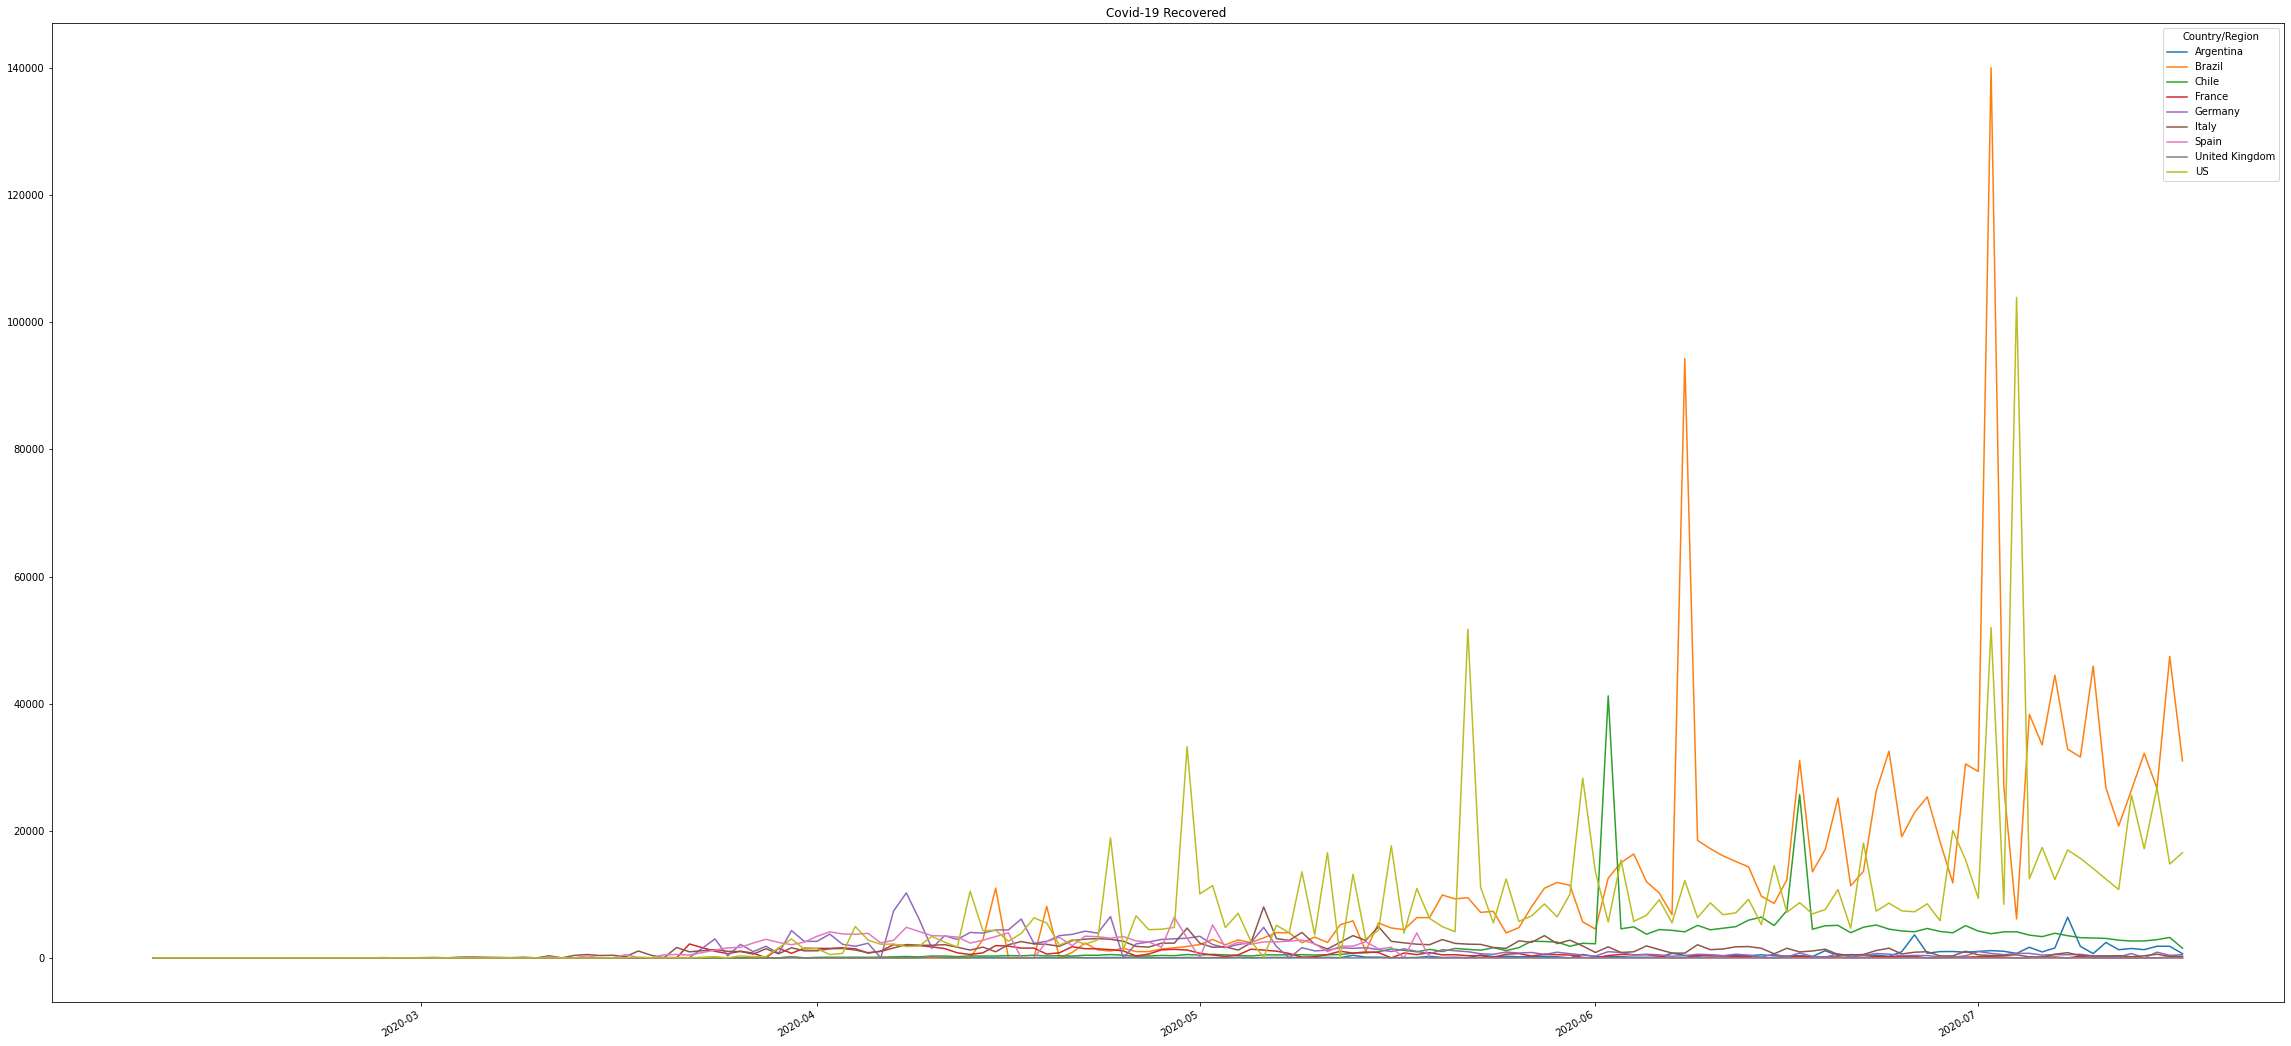

In [40]:
new_recovered_df.transpose().plot(kind='line', title='Covid-19 Recovered ', 
                                  logy=False)

## Calculate death rate based on all cases (recovered, deaths, still with Covid-19)

In [41]:
death_rate_vs_confirmed = selected_deaths_df.iloc[:,-1] \
                          / selected_confirmed_df.iloc[:,-1] 
death_rate_vs_confirmed

Country/Region
Argentina         0.018256
Brazil            0.038044
Chile             0.025570
France            0.149165
Germany           0.044980
Italy             0.143577
Spain             0.109201
United Kingdom    0.154253
US                0.038179
Name: 2020-07-17 00:00:00, dtype: float64

## Calculate death rate based on number of recovered patients plus deaths

In [42]:
death_rate_vs_recovered = selected_deaths_df.iloc[:,-1] / \
                          (selected_recovered_df.iloc[:,-1] + \
                           selected_deaths_df.iloc[:,-1])
death_rate_vs_recovered

Country/Region
Argentina         0.041918
Brazil            0.051681
Chile             0.027353
France            0.294517
Germany           0.046370
Italy             0.151302
Spain             0.158952
United Kingdom    1.000000
US                0.111728
Name: 2020-07-17 00:00:00, dtype: float64

## Calculate reproduction number 
Last four days vs. previous four days 

```Reff(t) = (N(t)+N(t-1)+N(t-2)+N(t-3)) / (N(t-4)+N(t-5)+N(t-6)+N(t-7))``` 

In [43]:
# divide new cases from last four days with new cases from previous four days
reproduction_df = (new_confirmed_df.iloc[:,-1] \
                   + new_confirmed_df.iloc[:,-2] \
                   + new_confirmed_df.iloc[:,-3] \
                   + new_confirmed_df.iloc[:,-4]) \
                  / (new_confirmed_df.iloc[:,-5] \
                   + new_confirmed_df.iloc[:,-6] \
                   + new_confirmed_df.iloc[:,-7] \
                   + new_confirmed_df.iloc[:,-8])
reproduction_df

Country/Region
Argentina         1.275533
Brazil            1.249040
Chile             0.767590
France            1.034685
Germany           1.581849
Italy             0.850058
Spain             1.484984
United Kingdom    1.236465
US                1.151687
dtype: float64